In [145]:
import scanpy as sc
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append(str(Path.cwd().parent))
from utils.adata import *
from utils.latent import *
from utils.plot import *
from utils.evaluation import *
import json
from sklearn.neighbors import NearestNeighbors
from umap import UMAP
import torch
import torch.nn.functional as F
import anndata
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.decomposition import PCA
from src.scDiffusion import VAE, guided_diffusion
from src.scDiffusion.VAE.VAE_model import *
import glob

In [140]:
adata = sc.read_h5ad("../data/hematopoiesis.h5ad")

In [146]:
adata.obs["celltype"] = adata.obs["cell_type"].map(
    {"HSC": "HSC", "CMP": "CMP", "GMP": "GMP"}
)
adata.obs["celltype"] = adata.obs["celltype"].astype("category")

In [147]:
adata.obs["period"] = adata.obs["celltype"]

In [5]:
adata.write("../data/hem_diff.h5ad")

In [6]:
adata

AnnData object with n_obs × n_vars = 3870 × 2000
    obs: 'GSM_ID', 'biomaterial_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'dpt_pseudotime', 'cell_type', 'celltype', 'period'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'biomaterial_name_colors', 'cell_type_colors', 'diffmap_evals', 'hvg', 'iroot', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_diffmap', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

### Train the SCimilarity VAE

In [5]:
!python ../src/scDiffusion/VAE/VAE_train.py \
--data_dir '../data/hem_diff.h5ad' \
--num_genes 2000 \
--save_dir '../models/scdiff/hem/VAE' \
--state_dict '../models/scdiff/annotation_model_v1/' \
--max_steps 200000


loading pretrained model from: 
 {'encoder': '../models/scdiff/annotation_model_v1/encoder.ckpt', 'decoder': '../models/scdiff/annotation_model_v1/decoder.ckpt', 'gene_order': '../models/scdiff/annotation_model_v1/gene_order.tsv'}
step  0 loss  1.2739801406860352
step  1000 loss  0.544532299041748
step  2000 loss  0.4808112382888794
step  3000 loss  0.3945019841194153
step  4000 loss  0.34333375096321106
step  5000 loss  0.3184998333454132
step  6000 loss  0.2883681058883667
step  7000 loss  0.2737604081630707
step  8000 loss  0.2598544657230377
step  9000 loss  0.2417260706424713
step  10000 loss  0.2357143610715866
step  11000 loss  0.2344638854265213
step  12000 loss  0.21226294338703156
step  13000 loss  0.2073047012090683
step  14000 loss  0.21185679733753204
step  15000 loss  0.1888638436794281
step  16000 loss  0.18898899853229523
step  17000 loss  0.19042545557022095
step  18000 loss  0.18745706975460052
step  19000 loss  0.17775923013687134
step  20000 loss  0.174361914396286


### Train the diffusion backbone

In [11]:
!python ../src/scDiffusion/cell_train.py \
  --data_dir '../data/hem_diff.h5ad' \
  --vae_path '../models/scdiff/hem/VAE/model_seed=0_step=199999.pt' \
  --model_name 'diffusion' \
  --save_dir '../models/scdiff/hem' \
  --batch_size 128 \
  --lr 0.5e-5 \
  --lr_anneal_steps 20000

Logging to ../models/scdiff/emt/diffusion/logs/diffusion
creating model and diffusion...
creating data loader...
training...
-------------------------
| grad_norm  | 0.867    |
| loss       | 1.12     |
| loss_q0    | 1.17     |
| loss_q1    | 1.12     |
| loss_q2    | 1.27     |
| loss_q3    | 1.28     |
| mse        | 1.12     |
| mse_q0     | 1.17     |
| mse_q1     | 1.12     |
| mse_q2     | 1.27     |
| mse_q3     | 1.28     |
| param_norm | 79       |
| samples    | 128      |
| step       | 0        |
-------------------------
saving model 0...
saving model 0.9999...
-------------------------
| grad_norm  | 0.638    |
| loss       | 1.02     |
| loss_q0    | 0.937    |
| loss_q1    | 1.17     |
| loss_q2    | 1.08     |
| loss_q3    | 0.966    |
| mse        | 1.02     |
| mse_q0     | 0.937    |
| mse_q1     | 1.17     |
| mse_q2     | 1.08     |
| mse_q3     | 0.966    |
| param_norm | 79       |
| samples    | 1.29e+04 |
| step       | 100      |
-------------------------
--

In [141]:
device     = "cuda" if torch.cuda.is_available() else "cpu"
batch_size = 512
num_cells, num_genes = adata.shape

In [142]:
X = adata.X
if not isinstance(X, np.ndarray):
    X = X.toarray()

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
X = adata.X
if not isinstance(X, np.ndarray):
    X = X.toarray()

In [143]:
latent_dim = 128  

model = VAE(
    num_genes=num_genes,
    hidden_dim=latent_dim,
    device=device,
    seed=0,
    decoder_activation="ReLU",
)
state = torch.load('../models/scdiff/hem/VAE/model_seed=0_step=199999.pt', map_location=device)
model.load_state_dict(state)
model.to(device)
model.eval()

VAE(
  (encoder): Encoder(
    (network): ModuleList(
      (0): Sequential(
        (0): Dropout(p=0.0, inplace=False)
        (1): Linear(in_features=2000, out_features=1024, bias=True)
        (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): PReLU(num_parameters=1)
      )
      (1-2): 2 x Sequential(
        (0): Dropout(p=0.0, inplace=False)
        (1): Linear(in_features=1024, out_features=1024, bias=True)
        (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): PReLU(num_parameters=1)
      )
      (3): Linear(in_features=1024, out_features=128, bias=True)
    )
  )
  (decoder): Decoder(
    (network): ModuleList(
      (0): Sequential(
        (0): Linear(in_features=128, out_features=1024, bias=True)
        (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): PReLU(num_parameters=1)
      )
      (1-2): 2 x Sequential(
        (

In [144]:
X_latent = np.zeros((num_cells, latent_dim), dtype=np.float32)

with torch.no_grad():
    for start in range(0, num_cells, batch_size):
        end = min(start + batch_size, num_cells)
        batch = torch.tensor(X[start:end], dtype=torch.float32, device=device)

        z = model.encoder(batch)    

        X_latent[start:end] = z.cpu().numpy()

### Train the classifier

In [13]:
!python ../src/scDiffusion/classifier_train.py \
  --data_dir '../data/hem_diff.h5ad' \
  --vae_path '../models/scdiff/hem/VAE/model_seed=0_step=199999.pt' \
  --model_path '../models/scdiff/hem/classifier/' \
  --num_class 3 \
  --batch_size 64 \
  --iterations 10000 \
  --lr 1e-3 \
  --weight_decay 0.0 \
  --log_interval 100 \
  --save_interval 1000 \
  --noised False

Logging to /tmp/openai-2025-12-11-12-28-45-390786
creating model and diffusion...
Running in single GPU mode without DDP
creating data loader...
creating optimizer...
training classifier model...
-----------------------------
| grad_norm      | 3.04     |
| param_norm     | 49.8     |
| samples        | 64       |
| step           | 0        |
| train_acc@1    | 0.281    |
| train_acc@1_q0 | 1        |
| train_loss     | 1.2      |
| train_loss_q0  | 0.81     |
-----------------------------
-----------------------------
| grad_norm      | 1.44     |
| param_norm     | 50       |
| samples        | 6.46e+03 |
| step           | 100      |
| train_acc@1    | 0.844    |
| train_acc@1_q0 | 0        |
| train_loss     | 0.492    |
| train_loss_q0  | 1.24     |
-----------------------------
-----------------------------
| grad_norm      | 1.27     |
| param_norm     | 50.4     |
| samples        | 1.29e+04 |
| step           | 200      |
| train_acc@1    | 0.812    |
| train_acc@1_q0 | 1    

### Generate Trajectory

In [173]:
!python ../src/scDiffusion/classifier_sample.py 

Logging to /tmp/openai-2025-12-11-18-03-06-170560
creating model and diffusion...
loading classifier...
sampling...
step  0
step  200
step  400
step  600
step  800
created 128 samples
step  0
step  200
step  400
step  600
step  800
created 256 samples
Saved 256 cells to ../data/generated/interpolation_0.npz
sampling complete
Logging to /tmp/openai-2025-12-11-18-03-12-552822
creating model and diffusion...
loading classifier...
sampling...
step  0
step  200
step  400
step  600
step  800
created 128 samples
step  0
step  200
step  400
step  600
step  800
created 256 samples
Saved 256 cells to ../data/generated/interpolation_1.npz
sampling complete
Logging to /tmp/openai-2025-12-11-18-03-16-060535
creating model and diffusion...
loading classifier...
sampling...
step  0
step  200
step  400
step  600
step  800
created 128 samples
step  0
step  200
step  400
step  600
step  800
created 256 samples
Saved 256 cells to ../data/generated/interpolation_2.npz
sampling complete
Logging to /tmp/ope

In [174]:
paths = sorted(
    glob.glob("../data/generated/interpolation_*.npz"),
    key=lambda x: int(x.split("_")[-1].split(".")[0])
)
paths

['../data/generated/interpolation_0.npz',
 '../data/generated/interpolation_1.npz',
 '../data/generated/interpolation_2.npz',
 '../data/generated/interpolation_3.npz',
 '../data/generated/interpolation_4.npz',
 '../data/generated/interpolation_5.npz',
 '../data/generated/interpolation_6.npz',
 '../data/generated/interpolation_7.npz',
 '../data/generated/interpolation_8.npz',
 '../data/generated/interpolation_9.npz',
 '../data/generated/interpolation_10.npz']

In [175]:
Z_list = []
step_list = []

for i, path in enumerate(paths):
    d = np.load(path)
    z_i = d["cell_gen"]          
    Z_list.append(z_i)
    step_list.append(np.full(z_i.shape[0], i, dtype=int))  

Z = np.vstack(Z_list)            
steps = np.concatenate(step_list)


In [176]:
N_target = 200
N_total = Z.shape[0]

idx = np.linspace(0, N_total - 1, N_target).astype(int)

Z = Z[idx]

In [177]:
with torch.no_grad():
    z_t = torch.tensor(Z, dtype=torch.float32, device=device)

    X_syn = model.decoder(z_t)

    X_syn = X_syn.cpu().numpy() 

In [178]:
adata_interpolated_cells = anndata.AnnData(X_syn)

In [179]:
adata_interpolated_cells.var_names = adata.var_names
adata_interpolated_cells.obs['cell_type'] = 'Interpolated'

In [183]:
adata = sc.read_h5ad("../data/hematopoiesis.h5ad")

In [184]:
combined_adata = combine_adatas(adata, adata_interpolated_cells)

/mnt/home/islamsa3/anaconda3/envs/global/lib/python3.10/site-packages/scanpy/neighbors/__init__.py:577: UserWarning: You’re trying to run this on 2000 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  x = _choose_representation(self._adata, use_rep=use_rep, n_pcs=n_pcs)


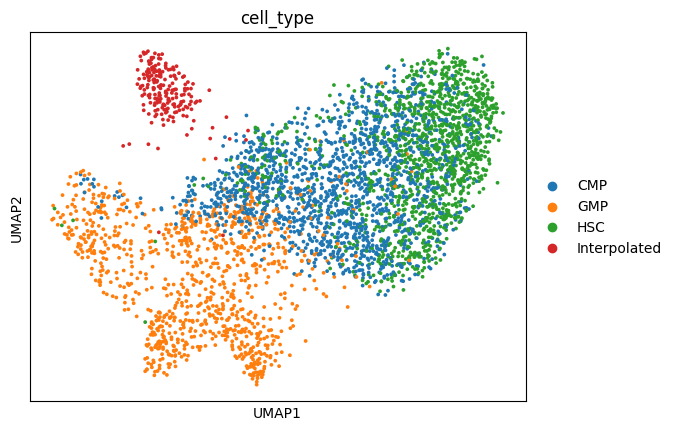

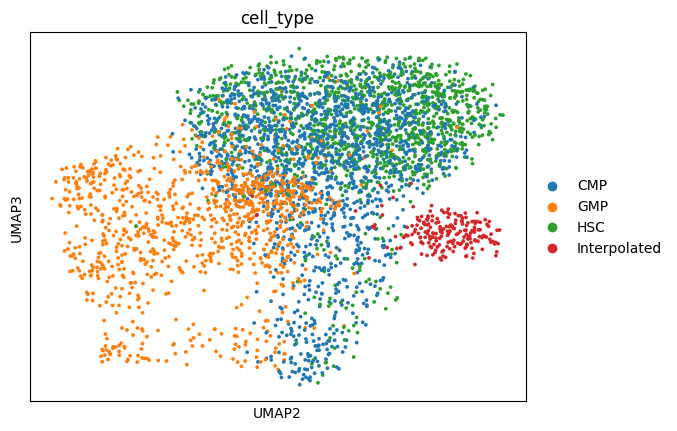

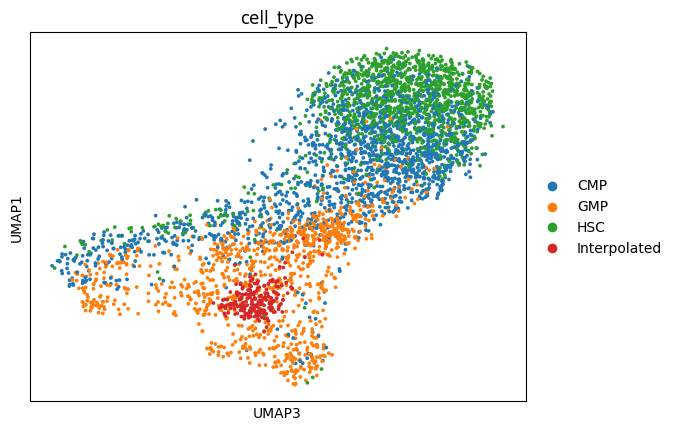

In [185]:
plot_umap(combined_adata, 'cell_type')

Available hsc markers: ['THY1', 'KIT', 'GATA2']
Available cmp markers: ['TFRC', 'KIT', 'IRF8']
Available gmp markers: ['CEBPA', 'CEBPD', 'MPO']


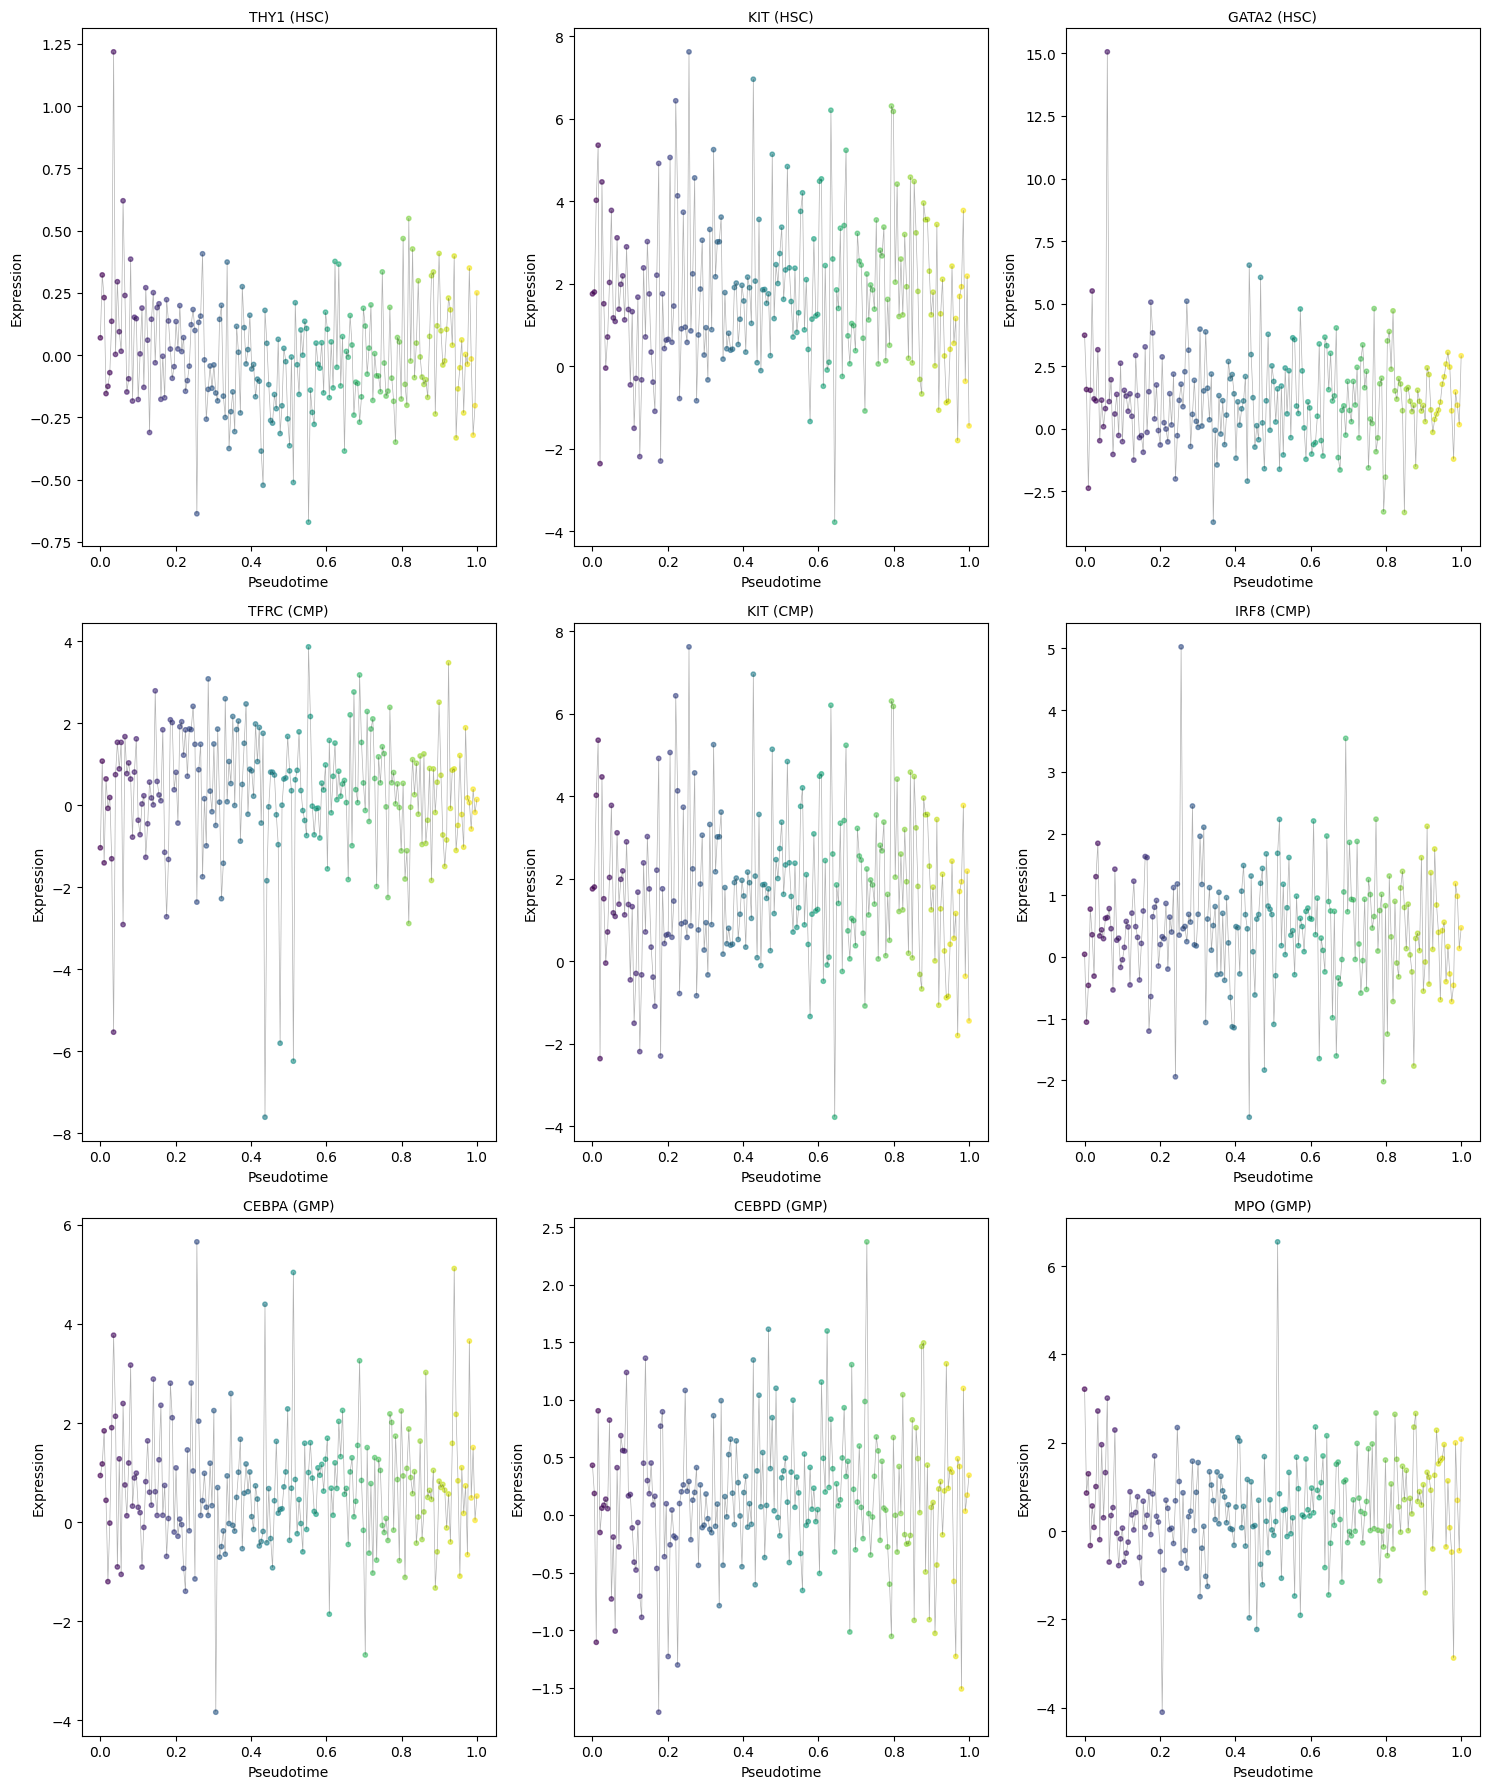

In [186]:
hsc_markers = ['THY1', 'KIT', 'GATA2']
cmp_markers = ['TFRC', 'KIT', 'IRF8']
gmp_markers = ['CEBPA', 'CEBPD', 'MPO']

gene_names = adata.var['gene_short_name'].values if 'gene_short_name' in adata.var else adata.var_names.values

available_hsc = [g for g in hsc_markers if g in gene_names]
available_cmp = [g for g in cmp_markers if g in gene_names]
available_gmp = [g for g in gmp_markers if g in gene_names]

print(f"Available hsc markers: {available_hsc}")
print(f"Available cmp markers: {available_cmp}")
print(f"Available gmp markers: {available_gmp}")

if available_hsc or available_cmp or available_gmp:
    n_markers = len(available_hsc) + len(available_cmp) + len(available_gmp)
    n_cols = 3
    n_rows = 3
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 6*n_rows))
    axes = axes.flatten() if n_markers > 1 else [axes]
    
    pseudotime = np.linspace(0,1,len(X_syn))
    
    plot_idx = 0
    for gene in available_hsc:
        gene_idx = np.where(gene_names == gene)[0][0]
        expression = X_syn[:, gene_idx]
        
        ax = axes[plot_idx]
        ax.scatter(pseudotime, expression, c=pseudotime, cmap='viridis', s=10, alpha=0.6)
        ax.plot(pseudotime, expression, 'k-', alpha=0.3, linewidth=0.5)
        ax.set_xlabel('Pseudotime')
        ax.set_ylabel('Expression')
        ax.set_title(f'{gene} (HSC)', fontsize=10)
        plot_idx += 1
    
    for gene in available_cmp:
        gene_idx = np.where(gene_names == gene)[0][0]
        expression = X_syn[:, gene_idx]
        
        ax = axes[plot_idx]
        ax.scatter(pseudotime, expression, c=pseudotime, cmap='viridis', s=10, alpha=0.6)
        ax.plot(pseudotime, expression, 'k-', alpha=0.3, linewidth=0.5)
        ax.set_xlabel('Pseudotime')
        ax.set_ylabel('Expression')
        ax.set_title(f'{gene} (CMP)', fontsize=10)
        plot_idx += 1

    for gene in available_gmp:
        gene_idx = np.where(gene_names == gene)[0][0]
        expression = X_syn[:, gene_idx]
        
        ax = axes[plot_idx]
        ax.scatter(pseudotime, expression, c=pseudotime, cmap='viridis', s=10, alpha=0.6)
        ax.plot(pseudotime, expression, 'k-', alpha=0.3, linewidth=0.5)
        ax.set_xlabel('Pseudotime')
        ax.set_ylabel('Expression')
        ax.set_title(f'{gene} (GMP)', fontsize=10)
        plot_idx += 1
    
    for i in range(plot_idx, len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()
else:
    print("No common markers found in the dataset")

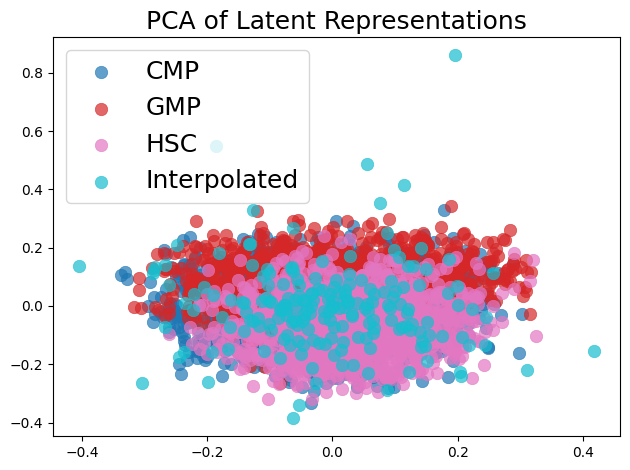

In [187]:
original_labels = adata.obs['cell_type'].values
interpolated_labels = np.array(['Interpolated'] * len(adata_interpolated_cells))

combined_latent = np.vstack([X_latent, Z])
combined_labels = np.concatenate([original_labels, interpolated_labels])

pca = PCA(n_components=2, random_state=42)
latent_pca = pca.fit_transform(combined_latent)


unique_labels = np.unique(combined_labels)

unique_colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))
palette = {label: unique_colors[i] for i, label in enumerate(unique_labels)}

for i, label in enumerate(unique_labels):
    mask = combined_labels == label
    plt.scatter(
        latent_pca[mask, 0], 
        latent_pca[mask, 1],
        color=palette[label],
        label=label,
        alpha=0.7,
        s=50 if label == 'interpolated' else 80,
        #edgecolors='w',
        linewidths=0.5
    )

plt.title('PCA of Latent Representations', fontsize=18)
plt.legend(fontsize=18)
plt.tight_layout()

/mnt/home/islamsa3/anaconda3/envs/global/lib/python3.10/site-packages/scanpy/neighbors/__init__.py:577: UserWarning: You’re trying to run this on 128 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  x = _choose_representation(self._adata, use_rep=use_rep, n_pcs=n_pcs)


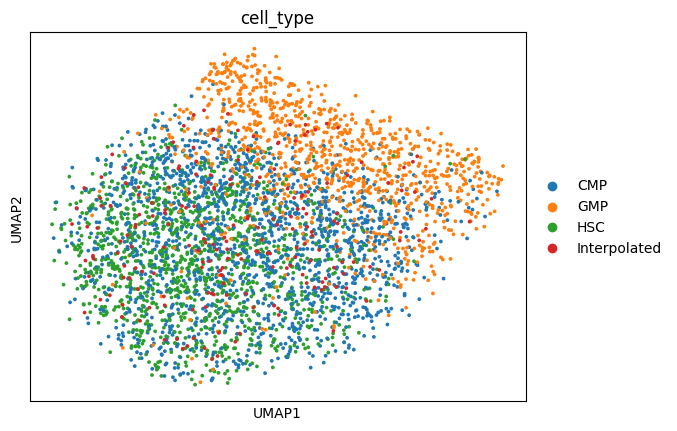

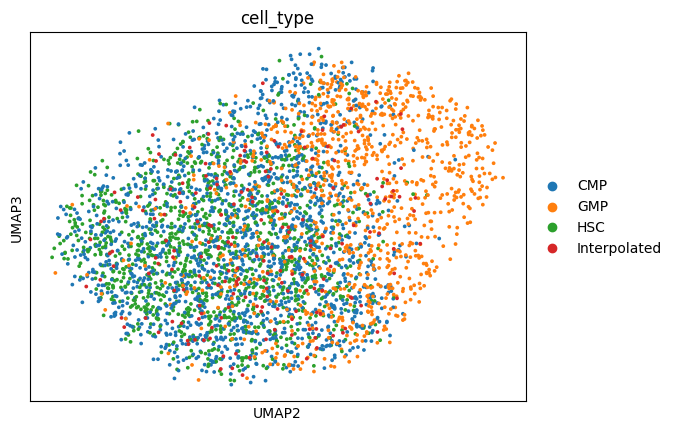

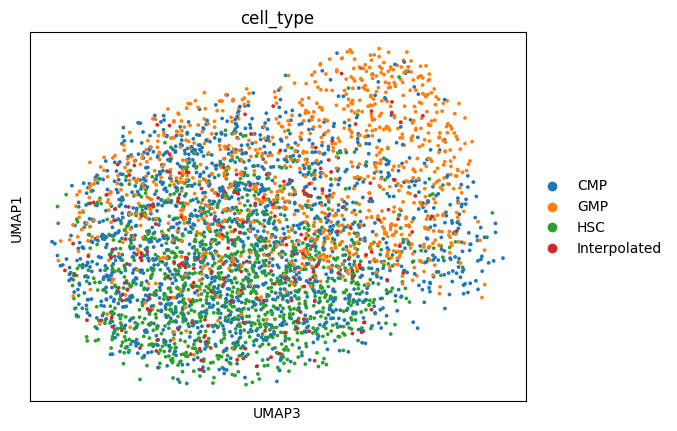

In [188]:
adata_latent_syn = anndata.AnnData(Z)
adata_latent_syn.obs["cell_type"] = "Interpolated"
adata_new = anndata.AnnData(
    X=X_latent,
    obs=adata.obs[['cell_type']].copy()
)
combined_adata_latent = combine_adatas(adata_new, adata_latent_syn)
plot_umap(combined_adata_latent, "cell_type")

In [189]:
pt_df, pt_summary = evaluate_pseudotime_distance_error(
    X_syn,
    np.linspace(0, 1, len(X_syn)),
    adata,
    list(gene_names),
    real_pseudotime_key="dpt_pseudotime",
)

print(pt_summary)
pt_df.head()

{'delta_t_mean': 0.30258047652145353, 'delta_t_median': 0.2663316582914573, 'delta_t_max': 0.9379053045457332, 'dist_mean': 40.803096523284914, 'dist_median': 37.404380798339844, 'dist_max': 133.1907958984375}


,alpha,nearest_pseudotime,delta_t,dist_to_nearest
0,0.000000,0.504301,0.504301,44.344837
1,0.005025,0.274596,0.269571,34.373894
2,0.010050,0.480008,0.469958,41.153824
3,0.015075,0.208137,0.193061,48.065960
4,0.020101,0.299251,0.279151,42.032948


In [190]:
dist_series, dist_summary = evaluate_distance_to_manifold_smoothness(
    X_syn,
    adata,
    list(gene_names),
)

print(dist_summary)

{'dist_mean': 40.803096523284914, 'dist_median': 37.404380798339844, 'dist_max': 133.1907958984375, 'smooth_mean_abs_delta': 15.966036772608158, 'smooth_max_abs_delta': 104.08462333679199}


In [191]:
marker_sets = {
    "HSC": ['THY1', 'KIT', 'GATA2'],
    "CMP": ['TFRC', 'KIT', 'IRF8'],
    "GMP": ['CEBPA', 'CEBPD', 'MPO']
}

expected_directions = {
    "HSC": -1,   
    "CMP": 1,   
    "GMP": 1,   
}


df_markers, summary_markers = evaluate_marker_monotonicity_general(
    X_syn=X_syn,
    traj_coord=np.linspace(0, 1, len(X_syn)),      
    gene_list=list(gene_names),
    marker_sets=marker_sets,
    expected_directions=expected_directions,

)

print(summary_markers)
df_markers.head()


  group  n_genes  mean_rho  median_rho  frac_sign_ok
0   CMP        3 -0.021271   -0.013905      0.333333
1   GMP        3  0.064925    0.061131      0.666667
2   HSC        3 -0.006522    0.017421      0.333333


,group,gene,rho,pval,expected_dir,sign_ok
0,HSC,THY1,-0.069129,0.330717,-1,True
1,HSC,KIT,0.017421,0.806572,-1,False
2,HSC,GATA2,0.032141,0.651403,-1,False
3,CMP,TFRC,-0.067328,0.343504,1,False
4,CMP,KIT,0.017421,0.806572,1,True


In [ ]:
adata_interpolated_cells.write_h5ad('../data/syn_hem_scdiff.h5ad')

: 